In [2]:
# import dsoclasses
import datetime
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations

In [3]:
# set the name of the DORIS RINEX file to use
drinex = "../data/s6arx24001.001"

# set the name of the Sp3 file for the same satellite, covering the same day
dsp3 = "../data/ssas6a20.b23357.e24001.DG_.sp3.001"

In [13]:
# we will need to interpolate the satellite orbit:
sp3 = sp3c.Sp3(dsp3)
# set the id of the satellite we need; it should be the first (and only) satellite in the sp3 list
satid = sp3.sat_ids[0]
# extract its data
sp3_data = sp3.get_satellite(satid, True)
# construct an Interpolator
intrp = interpolator.OrbitInterpolator(satid, sp3_data, 1800, 12, 'CubicSpline')

In [14]:
# create a DORIS RINEX instance; this will parse the data file's header
rnx = DorisRinex(drinex)

# Select a DORIS beacon (out of the RINEX list) to extract data
diob = 'D31'

In [15]:
# store here arrays to plot (time and temperature)
t = []; L1 = [];

# loop through all data blocks ...
for block in rnx:
    # loop through all beacons of the data block ...
    for beacon, data in block:
        # now k is the beacon id (e.f. 'D01') and v holds the measured data, e.g. 
        # {'L1': {'value': -2446791.601, 'm1': None, 'm2': None}, 'L2': {'value': -3849973.536, 'm1': None, 'm2': None}, 'C1': ..., 'H': {'value': 70.005, 'm1': None, 'm2': 1}}
        if beacon == diob:
            # store values for later usage
            t.append(block.t())
            L1.append(data['L1']['value'])

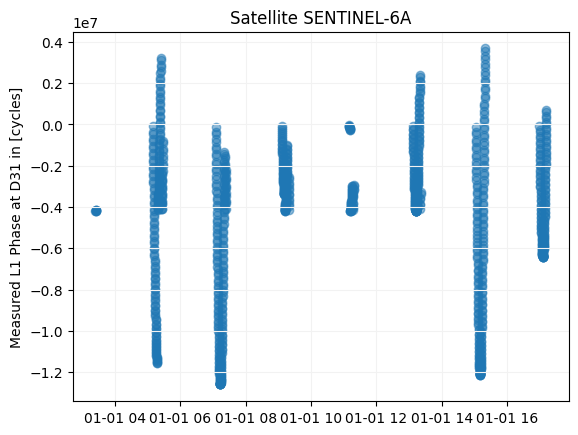

In [16]:
# import modules for plotting ...
import matplotlib.pyplot as plt
import numpy as np

# create a scatterplot of extracted L1 values w.r.t. time
plt.scatter([at2pt(ti) for ti in t], L1, alpha=0.5)
plt.grid(color='0.95')
plt.ylabel("Measured L1 Phase at {:} in [cycles]".format(diob))
plt.title("Satellite {:}".format(rnx.sat_name))
plt.show()

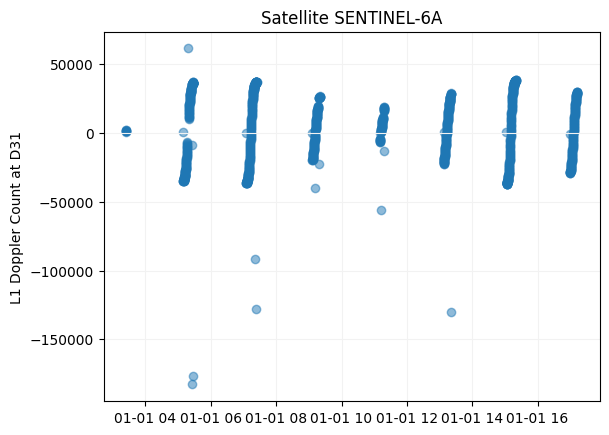

In [17]:
# create a scatterplot of L1 Doppler count w.r.t. time
Ndop = []; tn = [];
for idx, ti in enumerate(t[0:-1]):
    Ndop.append((L1[idx+1] - L1[idx]) / float((t[idx+1] - t[idx]).total_seconds()))
    tn.append(t[idx+1])

plt.scatter([at2pt(ti) for ti in tn], Ndop, alpha=0.5)
plt.grid(color='0.95')
plt.ylabel("L1 Doppler Count at {:}".format(diob))
plt.title("Satellite {:}".format(rnx.sat_name))
plt.show()

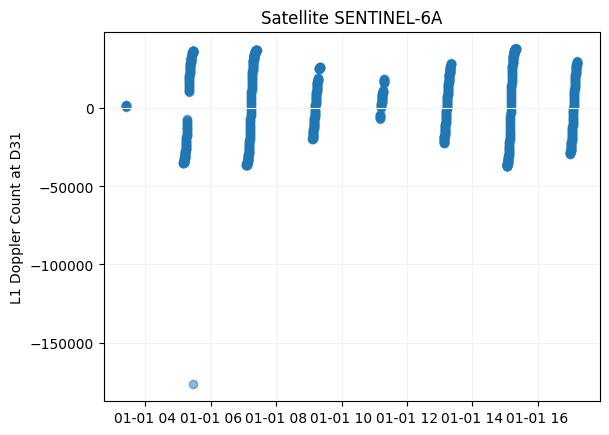

In [18]:
# create a scatterplot of L1 Doppler count w.r.t. time
Ndop = []; tn = [];
for idx, ti in enumerate(t[0:-1]):
    if (t[idx+1] - t[idx]).total_seconds() < 11.:
        Ndop.append((L1[idx+1] - L1[idx]) / float((t[idx+1] - t[idx]).total_seconds()))
        tn.append(t[idx+1])

plt.scatter([at2pt(ti) for ti in tn], Ndop, alpha=0.5)
plt.grid(color='0.95')
plt.ylabel("L1 Doppler Count at {:}".format(diob))
plt.title("Satellite {:}".format(rnx.sat_name))
plt.show()

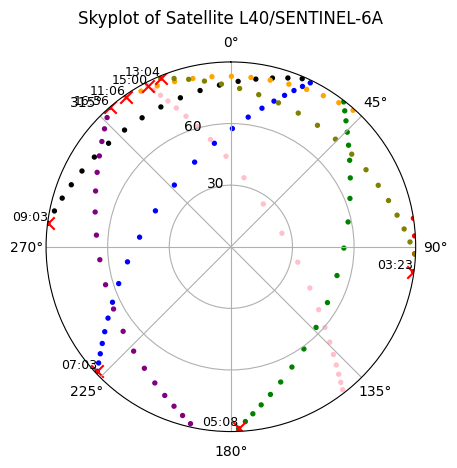

In [19]:
# skyplot
#
# get the ellipsoidal coordinates of the site; approximate cartesian coordinates 
# for any site/beacon can be found from the relevant site log at the IDS site,
#
DIOB_xyz = [4595220.016, 2039434.081, 3912626.007]
lat, lon, hgt = transformations.car2ell(*DIOB_xyz)
# compute the (e,n,u) to (x, y, z) rotation matrix
Rt = transformations.geodetic2lvlh(lat, lon)
# and get it's inverse (i.e. (dx, dy, dz) to (e, n, u))
R = Rt.transpose()

# data to plot (different colors for each pass)
azs = []; els = []; colors = []; c=['red','green','blue','black','orange', 'olive', 'pink', 'purple', 'brown', 'gray']
# entr points (of each pass)
entries_az = []; entries_el = []; entries_t = [];
last_elevation_was = -np.pi
color_idx = -1

# iterate through satellite positions (as recorded in the Sp3)
for k,v in sp3_data.items():
    # we are only plotting the day of interest
    if k >= at2pt(rnx.time_first_obs) and k<at2pt(rnx.time_first_obs)+datetime.timedelta(hours=24):
    # cartesian difference vector
        dx = v['x'] - DIOB_xyz[0]
        dy = v['y'] - DIOB_xyz[1]
        dz = v['z'] - DIOB_xyz[2]
        # topocentric vector
        enu = R @ [dx, dy, dz]
        # compute azimouth and elevation
        r  = np.linalg.norm(enu)
        az = np.arctan2(enu[0], enu[1])
        el = np.arcsin(enu[2] / r)
        # only plotting if elevation is above horizon
        if el >= 0:
            azs.append(az)
            els.append(90e0 - np.degrees(el))
            colors.append(c[color_idx])
        # store data point if entry point (i.e. start of new pass)
        if last_elevation_was <= 0 and el > 0:
            entries_az.append(az)
            entries_el.append(90e0 - np.degrees(el))
            entries_t.append(k)
            color_idx += 1
            colors[-1] = c[color_idx]
        last_elevation_was = el

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# data points
ax.scatter(azs, els, c=colors, s=2*4)
# entry points
ax.scatter(entries_az, entries_el, marker='x', c='red', s=4*20)
# time of entry
for i in range(len(entries_t)):
    ax.text(entries_az[i], entries_el[i], entries_t[i].strftime("%H:%M"),
    fontsize=9, ha='right', va='bottom')
ax.set_rmax(90)
ax.set_rticks([30, 60])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

# Rotate the angle axis by -90 degrees (make 0 degrees point up)
ax.set_theta_zero_location('N')  # Set 0° to the top (North)
ax.set_theta_direction(-1)  # Make the angles increase clockwise

σπέρα. Στο πλαίσιο των μεταπτυχιακών μου σπουδών στο ΠΜΣ "Κλινική ψυχική υγεία" της Ιατρικής Σχολής του ΑΠΘ, διεξάγω έρευνα με σκοπό τη μελέτη ορισμένων πτυχών της σχέσης μεταξύ ψυχοθεραπευτή και θεραπευόμενου.
Το ερωτηματολόγιο απευθύνεται σε άτομα άνω των 18 ετών, που βρίσκονται αυτήν την περίοδο σε ψυχοθεραπευτική διαδικασία και έχουν πραγματοποιήσει τουλάχιστον πέντε συνεδρίες με τον τωρινό τους ψυχοθεραπευτή.
ax.set_title("Skyplot of Satellite {:}/{:}".format(satid, rnx.sat_name), va='bottom')
plt.show()

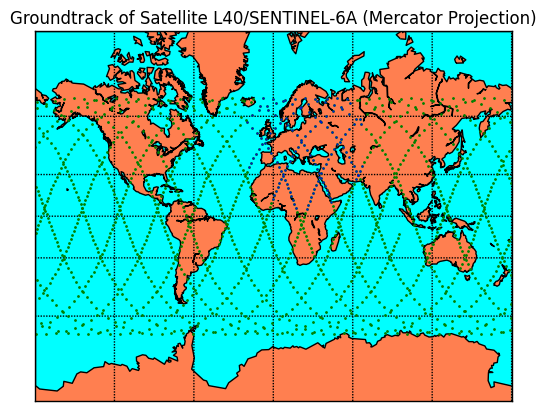

In [24]:
# groundtrack
#
from mpl_toolkits.basemap import Basemap

# concatenate satellite position vectors, and transform geocentric cartesian 
# crd to ellipsoidal
lons = []; lats = [];
observed_lons = []; observed_lats = [];
for k,v in sp3_data.items():
        # we are only plotting the day of interest
        if k >= at2pt(rnx.time_first_obs) and k<at2pt(rnx.time_first_obs)+datetime.timedelta(hours=24):
            phi, lamda, _ = transformations.car2ell(v['x'], v['y'], v['z'])
            lons.append(lamda); lats.append(phi);
            # cartesian difference vector
            dx = v['x'] - DIOB_xyz[0]
            dy = v['y'] - DIOB_xyz[1]
            dz = v['z'] - DIOB_xyz[2]
            # topocentric vector
            enu = R @ [dx, dy, dz]
            # compute azimouth and elevation
            r  = np.linalg.norm(enu)
            el = np.arcsin(enu[2] / r)
            if np.degrees(el) >= 0:
                observed_lons.append(lamda); observed_lats.append(phi);

# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
                llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')

# convert to map projection coords.
xpt,ypt = m(np.degrees(lons),np.degrees(lats))
m.plot(xpt,ypt,'go',linewidth=.1,markersize=1)
xpt,ypt = m(np.degrees(observed_lons),np.degrees(observed_lats))
m.plot(xpt,ypt,'bo',linewidth=.1,markersize=.5)

plt.title("Groundtrack of Satellite {:}/{:} (Mercator Projection)".format(satid, rnx.sat_name))
plt.show()